In [442]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import gaussian_filter

In [443]:

def visualize(arr: np.array, cmap: str = "viridis", flip: bool = False):
    img = np.copy(arr)
    img = img - img.min()
    img = img / img.max()
    plt.imshow(img, cmap=cmap, origin="upper")


def magnitude2(arrX: np.array, arrY: np.array):
    return np.sqrt(arrX**2 + arrY**2)


def interp2d(a, x, y):
    X = np.floor(x).astype(int)
    Y = np.floor(y).astype(int)
    fracX = x - X
    fracY = y - Y
    X = np.clip(X, 0, a.shape[0] - 2)
    Y = np.clip(Y, 0, a.shape[1] - 2)


    U1 = (1.0 - fracX) * a[X + 0, Y + 0] + fracX * a[X + 1, Y + 0]
    U2 = (1.0 - fracX) * a[X + 0, Y + 1] + fracX * a[X + 1, Y + 1]
    U = (1.0 - fracY) * U1 + fracY * U2
    return U

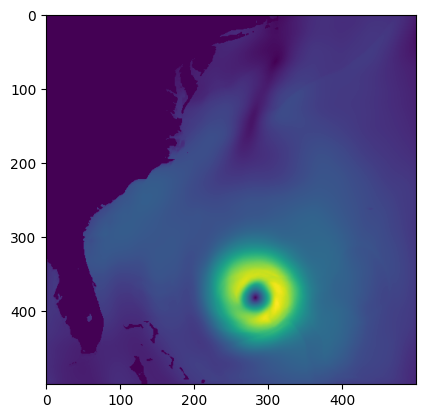

In [444]:
d1 = h5py.File("../isabel_2d.h5", "r")
u = np.array(d1["Velocity"]["X-comp"])
v = np.array(d1["Velocity"]["Y-comp"])
mag = magnitude2(u, v)
img = np.dstack([u, v, np.zeros_like(u)])
mesh_size = u.shape[0]
visualize(magnitude2(u, v))

In [ ]:
# generate noise texture
n = np.random.random(u.shape)

# perform LIC
l = 12_000
dt = 0.03/ np.max(magnitude2(u, v))
h = np.exp(-np.linspace(-2, 2, l)**2)  

h /= h.sum()
kernel_magnitude = sum(h)

In [446]:
i = np.arange(0, mesh_size).astype(float)
j = np.arange(0, mesh_size).astype(float)
ii, jj = np.meshgrid(i, j)

In [447]:
F = np.zeros_like(n)

F = h[0]*interp2d(n, ii, jj)

# fwd
xx, yy = ii, jj
for k in range(1, l):
    tmp_xx = xx
    xx += interp2d(u, xx, yy) * dt
    yy += interp2d(v, tmp_xx, yy) * dt
    F += h[k] * interp2d(n, xx, yy)
    print(f"{k}/{l}")
# bwd
xx, yy = ii, jj
for k in range(1, l):
    tmp_xx = xx
    xx -= interp2d(u, xx, yy) * dt
    yy -= interp2d(v, tmp_xx, yy) * dt
    F += h[k] * interp2d(n, xx, yy)
    print(f"{k}/{l}")
F /= (2*kernel_magnitude)

1/12000
2/12000
3/12000
4/12000
5/12000
6/12000
7/12000
8/12000
9/12000
10/12000
11/12000
12/12000
13/12000
14/12000
15/12000
16/12000
17/12000
18/12000
19/12000
20/12000
21/12000
22/12000
23/12000
24/12000
25/12000
26/12000
27/12000
28/12000
29/12000
30/12000
31/12000
32/12000
33/12000
34/12000
35/12000
36/12000
37/12000
38/12000
39/12000
40/12000
41/12000
42/12000
43/12000
44/12000
45/12000
46/12000
47/12000
48/12000
49/12000
50/12000
51/12000
52/12000
53/12000
54/12000
55/12000
56/12000
57/12000
58/12000
59/12000
60/12000
61/12000
62/12000
63/12000
64/12000
65/12000
66/12000
67/12000
68/12000
69/12000
70/12000
71/12000
72/12000
73/12000
74/12000
75/12000
76/12000
77/12000
78/12000
79/12000
80/12000
81/12000
82/12000
83/12000
84/12000
85/12000
86/12000
87/12000
88/12000
89/12000
90/12000
91/12000
92/12000
93/12000
94/12000
95/12000
96/12000
97/12000
98/12000
99/12000
100/12000
101/12000
102/12000
103/12000
104/12000
105/12000
106/12000
107/12000
108/12000
109/12000
110/12000
111/1200

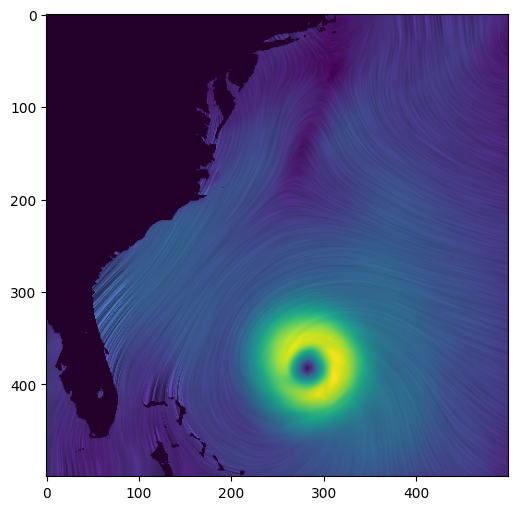

In [456]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_facecolor("black")

# normalize lic result
F_proc = np.copy(F.T)
F_proc[mag < 0.01] = 0.0
F_proc -= F_proc.min()
F_proc /= F_proc.max()

mag_proc = np.copy(mag)
mag_proc -= mag_proc.min()
mag_proc /= mag_proc.max()

cmap = plt.cm.viridis(mag_proc)

cmap[..., :3] *= F_proc[..., np.newaxis] + 0.5
plt.imshow(cmap)

plt.show()